In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin


#model building
from sklearn.ensemble import RandomForestRegressor

#model evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# to persist the model and the scaler
import joblib

In [2]:
 #defining feature names
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

In [3]:
train = pd.read_csv('../backend/CMAPSSData/train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
test = pd.read_csv('../backend/CMAPSSData/test_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
rul = pd.read_csv('../backend/CMAPSSDATA/RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])

In [5]:
def add_RUL_column(df):
    
    #get total number of cycles for each unit
    train_grouped_by_unit = df.groupby(by='unit_number') 
    max_time_cycles = train_grouped_by_unit['time_cycles'].max() 
    
    #merge the max cycle back into original frame
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    
    #calculate remaining useful life for each row
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    
    #drop max cycle as it's no longer needed
    merged = merged.drop("max_time_cycle", axis=1) 
    return merged
train = add_RUL_column(train)

In [52]:
drop_labels = index_names+setting_names

df = train.drop(columns = drop_labels.copy())
X = df.drop('RUL', axis=1).values
y = df['RUL'].values

X_train, X_test, y_train, y_test=train_test_split(
    X, #predictor
    y, #target
    test_size=0.3, #split
    random_state=0) #set seed for reproducibility

In [18]:
# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 10, 500)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()

# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X, y)
print("Best Params {}".format(lasso_cv.best_params_))

Best Params {'alpha': 1e-05}


In [19]:
names=df.drop("RUL", axis=1).columns
print("Column Names: {}".format(names.values))

Column Names: ['s_1' 's_2' 's_3' 's_4' 's_5' 's_6' 's_7' 's_8' 's_9' 's_10' 's_11'
 's_12' 's_13' 's_14' 's_15' 's_16' 's_17' 's_18' 's_19' 's_20' 's_21']


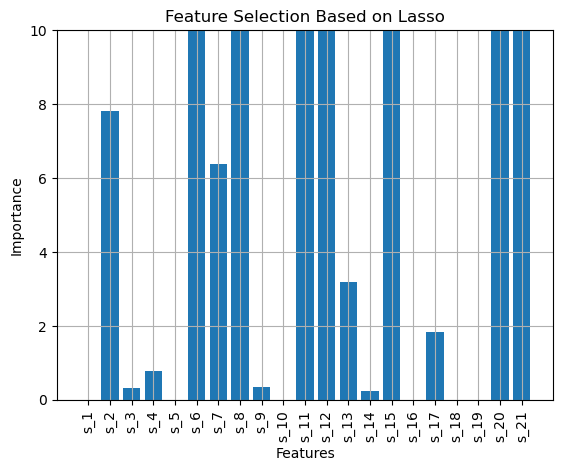

In [20]:
# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

# plotting the Column Names and Importance of Columns. 
plt.bar(names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0, 10)
plt.show()

In [21]:
# Subsetting the features which has more than 2 importance.
feature_subset=np.array(names)[lasso1_coef>2]
print("Selected Feature Columns: {}".format(feature_subset))

# Adding the target to the list of feaatures. 
feature_subset=np.append(feature_subset, "RUL")
print("Selected Columns: {}".format(feature_subset))

Selected Feature Columns: ['s_2' 's_6' 's_7' 's_8' 's_11' 's_12' 's_13' 's_15' 's_20' 's_21']
Selected Columns: ['s_2' 's_6' 's_7' 's_8' 's_11' 's_12' 's_13' 's_15' 's_20' 's_21' 'RUL']


In [22]:
df_new = df[feature_subset]
print(df_new.head())

      s_2    s_6     s_7      s_8   s_11    s_12     s_13    s_15   s_20  \
0  641.82  21.61  554.36  2388.06  47.47  521.66  2388.02  8.4195  39.06   
1  642.15  21.61  553.75  2388.04  47.49  522.28  2388.07  8.4318  39.00   
2  642.35  21.61  554.26  2388.08  47.27  522.42  2388.03  8.4178  38.95   
3  642.35  21.61  554.45  2388.11  47.13  522.86  2388.08  8.3682  38.88   
4  642.37  21.61  554.00  2388.06  47.28  522.19  2388.04  8.4294  38.90   

      s_21  RUL  
0  23.4190  191  
1  23.4236  190  
2  23.3442  189  
3  23.3739  188  
4  23.4044  187  


In [53]:
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('random_forest', RandomForestRegressor(random_state=0)),
])

In [55]:
X_train, X_test, y_train, y_test=train_test_split(
    df_new.drop('RUL', axis=1), #predictor
    df_new['RUL'], #target
    test_size=0.3, #split
    random_state=0) #set seed for reproducibility
X_train

,s_2,s_6,s_7,s_8,s_11,s_12,s_13,s_15,s_20,s_21
13175,642.22,21.61,553.20,2388.07,47.22,521.75,2388.04,8.4153,38.91,23.2453
1700,643.68,21.61,551.70,2388.20,47.98,519.97,2388.18,8.5054,38.43,23.1086
19098,642.35,21.61,553.44,2388.12,47.53,521.39,2388.16,8.4290,38.77,23.3332
18053,641.81,21.61,554.07,2388.05,47.22,522.39,2388.02,8.4157,39.08,23.4287
6376,643.06,21.61,552.29,2388.14,47.90,520.74,2388.11,8.4965,38.65,23.1552
...,...,...,...,...,...,...,...,...,...,...
13123,642.08,21.61,554.75,2388.07,47.36,521.90,2388.06,8.4489,39.04,23.3165
19648,642.99,21.61,554.42,2388.08,47.27,521.94,2388.07,8.4208,39.01,23.3831
9845,642.90,21.61,552.80,2388.09,47.58,521.08,2388.15,8.4656,38.81,23.2899
10799,642.10,21.61,553.31,2388.12,47.41,521.45,2388.09,8.4336,38.88,23.1794


In [56]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('random_forest', RandomForestRegressor(random_state=0))])

In [57]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_hat)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}, MAE:{}'.format(label, rmse, variance, mae))

In [58]:
pred_train = rf_pipeline.predict(X_train)
evaluate(y_train, pred_train)

pred_test = rf_pipeline.predict(X_test)
evaluate(y_test, pred_test)

test set RMSE:17.363176180198362, R2:0.9369347153047909, MAE:12.704775985042586
test set RMSE:46.41067829887375, R2:0.5377950689516431, MAE:34.37195153473344


In [76]:
X_valid = test.groupby('unit_number').last().reset_index().drop(columns=drop_labels)
X_valid_new = X_valid[feature_subset[:-1:]]
X_valid_new

,s_2,s_6,s_7,s_8,s_11,s_12,s_13,s_15,s_20,s_21
0,642.58,21.61,554.42,2388.08,47.23,521.79,2388.06,8.4024,38.81,23.3552
1,642.55,21.61,553.52,2388.10,47.67,521.74,2388.09,8.4505,38.81,23.2618
2,642.88,21.61,552.59,2388.16,47.88,520.83,2388.14,8.4119,38.93,23.2740
3,642.78,21.61,552.64,2388.13,47.65,521.88,2388.11,8.4634,38.58,23.2581
4,642.27,21.61,553.29,2388.10,47.46,521.00,2388.15,8.4362,38.75,23.4117
...,...,...,...,...,...,...,...,...,...,...
95,642.30,21.61,553.99,2388.03,47.14,522.30,2388.01,8.4110,38.96,23.4606
96,642.59,21.61,554.05,2388.06,47.38,521.58,2388.06,8.4500,38.61,23.2953
97,642.68,21.61,553.44,2388.13,47.66,521.53,2388.09,8.4235,38.76,23.3608
98,642.00,21.61,554.75,2388.01,47.26,521.82,2388.02,8.4003,38.95,23.3595


In [77]:
new_pred = rf_pipeline.predict(X_valid_new)
evaluate(rul, new_pred, label = 'valid')

valid set RMSE:37.54761851302956, R2:0.18359576426616087, MAE:27.391800000000007


In [67]:
class LassoFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, alpha_range=np.arange(0.00001, 10, 500), n_folds=5, random_state=42):
        self.alpha_range = alpha_range
        self.n_folds = n_folds
        self.random_state = random_state
        self.best_alpha_ = None
        self.feature_importance_ = None
        self.lasso_model = Lasso()

    def fit(self, X, y):
        # Define parameters for GridSearchCV
        params = {"alpha": self.alpha_range}
        
        # Initialize KFold with specified number of folds and random state
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        
        # Initialize GridSearchCV with Lasso model, parameters, and KFold
        lasso_cv = GridSearchCV(self.lasso_model, param_grid=params, cv=kf)
        
        # Perform grid search to find the best alpha
        lasso_cv.fit(X, y)
        
        # Store the best alpha found by GridSearchCV
        self.best_alpha_ = lasso_cv.best_params_['alpha']
        
        # Fit Lasso model with the best alpha
        self.lasso_model.set_params(alpha=self.best_alpha_)
        self.lasso_model.fit(X, y)
        
        # Compute the absolute coefficients (feature importance)
        self.feature_importance_ = np.abs(self.lasso_model.coef_)
        
        return self

    def transform(self, X):
        # This method can be used to transform the input X
        # For feature selection based on Lasso coefficients, 
        # you may choose to return X with selected features
        return X


In [38]:
fs_lasso = Pipeline([
    ('scaler', StandardScaler()),                    # Standardize the features
    ('lasso_selector', LassoFeatureSelector()),      # Apply Lasso feature selection with grid search
    ('lasso', Lasso())                               # Lasso regression
])

In [39]:
fs_lasso.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso_selector', LassoFeatureSelector()),
                ('lasso', Lasso())])

In [40]:
lasso_selector = pipeline.named_steps['lasso_selector']
lasso_coef = lasso_selector.feature_importance_